## 6.3 랭그래프 실습

### 6.3.1 [실습] Corrective-RAG

In [1]:
%%capture --no-stderr
! pip install langchain_community tiktoken langchain-openai langchainhub chromadb langchain langgraph tavily-python python-dotenv

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
from dotenv import load_dotenv

# .env 파일에서 환경 변수 로드
load_dotenv("/content/drive/MyDrive/Colab Notebooks/.env")

In [4]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings

# 크롤할 블로그의 url을 정의합니다 
urls = [
    "https://google.github.io/styleguide/pyguide.html",
    "https://google.github.io/styleguide/javaguide.html",
    "https://google.github.io/styleguide/jsguide.html",
]

# WebBaseLoader를 사용하여 주어진 URL 목록에서 문서를 크롤링합니다. 
docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

# 지정한 크기만큼 텍스트를 분할하는 텍스트 분할기를 설정합니다. 
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=250, chunk_overlap=0
)
# 문서를 분할합니다.
doc_splits = text_splitter.split_documents(docs_list)

# Chroma 벡터 저장소에 문서의 분할된 조각을 저장합니다.
vectorstore = Chroma.from_documents(
    documents=doc_splits,
    collection_name="rag-chroma",
    embedding=OpenAIEmbeddings(),
)
# 벡터 저장소에서 검색을 수행할 수 있는 검색기를 생성합니다.
retriever = vectorstore.as_retriever()

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [6]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_openai import ChatOpenAI


# 문서와 질문의 연관성을 평가하기 위한 데이터 모델을 정의합니다.
class GradeDocuments(BaseModel):
    binary_score: str = Field(
        description="문서와 질문의 연관성 여부. (예 or 아니오)"
    )


# 연관성 평가를 위한 LLM 을 정의합니다. 
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
structured_llm_grader = llm.with_structured_output(GradeDocuments)


# LLM이 사용자의 질문에 대해 문서의 연관성을 평가할 수 있도록 지시하는 프롬프트를 정의합니다.
system = """당신은  사용자의 질문에 대해 검색된 문서의 관련성을 평가하는 전문가입니다.
문서에 질문과 관련된 키워드나 의미가 담겨 있으면, 해당 문서를 ‘관련 있음’으로 평가하세요.
문서가 질문과 관련이 있는지 여부를 ‘예’ 또는 ‘아니오’로 표시해 주세요."""


# 시스템 메시지와 사용자의 질문 및 문서 내용을 포함한 템플릿을 만듭니다.
grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "검색된 문서: \n\n {document} \n\n 사용자 질문: {question}"),
    ]
)

# 프롬프트와 구조화된 LLM 평가기를 결합하여 retrieval_grader 객체를 만듭니다.
retrieval_grader = grade_prompt | structured_llm_grader

In [7]:
question = "파이썬 코드 작성 가이드"
# 연관문서 검색
docs = retriever.invoke(question)
doc_txt = docs[1].page_content
# 검색된 문서의 연관성 평가
print(retrieval_grader.invoke({"question": question, "document": doc_txt}))

binary_score='예'


In [15]:
from langchain_core.output_parsers import StrOutputParser

# LLM이 제공된 문맥을 바탕으로 답변할 수 있도록 지시하는 프롬프트를 정의합니다.
system = """당신은 질문에 답변하는 업무를 돕는 도우미입니다. 
제공된 문맥을 바탕으로 질문에 답변하세요. 만약 답을 모르면 모른다고 말하세요. 
세 문장을 넘지 않도록 답변을 간결하게 작성하세요."""
# 시스템 메시지와 사용자의 질문 및 문서 내용을 포함한 템플릿을 만듭니다.
prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "질문: {question} \n문맥: {context} \n답변:"),
    ]
)

# 검색된 문서들을 한 문자열로 합쳐줍니다
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

# 프롬프트, LLM, 문자열 출력을 결합하여 RAG 체인을 만듭니다.
rag_chain = prompt | llm | StrOutputParser()

In [16]:
# 정의된 RAG 체인을 사용하여 질문과 문맥을 기반으로 답변을 생성합니다. 
generation = rag_chain.invoke(
    {"context": format_docs(docs), "question": question}
)

# 생성된 답변을 출력합니다 
print(generation)

파이썬 코드 작성 가이드는 코드 포맷팅, 린트 사용, 그리고 스타일 규칙을 포함합니다. pylint를 사용하여 코드의 버그와 스타일 문제를 찾아야 하며, Google의 스타일 가이드를 따르는 것이 중요합니다. 자동 포맷터인 Black이나 Pyink을 사용하면 포맷팅에 대한 논쟁을 피할 수 있습니다.


In [18]:
# LLM이 입력된 질문을 웹검색에 적합한 형태로 변형하도록 지시하는 프롬프트를 정의합니다 
system = """당신은 입력된 질문을 변형하여 웹 검색에 최적화된 형태로 만드는 질문생성기입니다. 
입력된 질문을 보고 그 이면에 있는 의미나 의도를 파악해주세요."""
# 시스템 메시지와 사용자의 질문을 포함한 템플릿을 만듭니다 
re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        (
            "human", "질문: \n\n {question} \n 더 나은 질문으로 바꿔주세요.",
        ),
    ]
)

# 프롬프트, LLM, 문자열 출력을 결합하여 질문 변형 체인을 생성합니다.
question_rewriter = re_write_prompt | llm | StrOutputParser()

In [19]:
question = "C++ 깔끔하게 짜고싶다"
question_rewriter.invoke({"question": question})

'C++ 코드를 깔끔하고 효율적으로 작성하는 방법은 무엇인가요?'

In [20]:
from langchain_community.tools.tavily_search import TavilySearchResults

web_search_tool = TavilySearchResults(k=3)

In [21]:
from typing import List

from typing_extensions import TypedDict


class GraphState(TypedDict):
    question: str
    generation: str
    web_search: str
    documents: List[str]

In [22]:
from langchain.schema import Document


def retrieve(state):
    """
    문서를 검색합니다

    Args:
        state (dict): 현재 그래프의 상태

    Returns:
        state (dict): 검색된 문서를 포함한 새로운 상태
    """
    print("---검색---")
    question = state["question"]

    documents = retriever.invoke(question)
    return {"documents": documents, "question": question}


def generate(state):
    """
    답변을 생성합니다

    Args:
        state (dict): 현재 그래프의 상태

    Returns:
        state (dict): LLM이 생성한 답변을 포함한 새로운 상태
    """
    print("---생성---")
    question = state["question"]
    documents = state["documents"]

    generation = rag_chain.invoke({"context": documents, "question": question})
    return {"documents": documents, "question": question, "generation": generation}


def grade_documents(state):
    """
    검색된 문서가 질문과 연관이 있는지 평가합니다

    Args:
        state (dict): 현재 그래프의 상태

    Returns:
        state (dict): 연관이 있다고 판단된 문서가 업데이트된 상태
    """

    print("---문서와 질문의 연관성 평가---")
    question = state["question"]
    documents = state["documents"]

    filtered_docs = []
    web_search = "아니오"
    for d in documents:
        score = retrieval_grader.invoke(
            {"question": question, "document": d.page_content}
        )
        grade = score.binary_score
        if grade == "예":
            print("---평가: 연관 문서---")
            filtered_docs.append(d)
        else:
            print("---평가: 연관 없는 문서---")
            web_search = "예"
            continue
    return {"documents": filtered_docs, "question": question, "web_search": web_search}


def transform_query(state):
    """
    질문을 더 적합한 형태로 변환합니다

    Args:
        state (dict): 현재 그래프의 상태

    Returns:
        state (dict): 변환된 질문이 업데이트된 상태
    """

    print("---질문 변환---")
    question = state["question"]
    documents = state["documents"]

    better_question = question_rewriter.invoke({"question": question})
    return {"documents": documents, "question": better_question}


def web_search(state):
    """
    웹 검색을 수행합니다 

    Args:
        state (dict): 현재 그래프의 상태

    Returns:
        state (dict): 웹 검색 결과가 업데이트된 상태
    """

    print("---웹 검색---")
    question = state["question"]
    documents = state["documents"]

    docs = web_search_tool.invoke({"query": question})
    web_results = "\n".join([d["content"] for d in docs])
    web_results = Document(page_content=web_results)
    documents.append(web_results)

    return {"documents": documents, "question": question}


In [23]:
def decide_to_generate(state):
    """
    답변을 생성할지, 질문을 재 생성할지 결정합니다. 

    Args:
        state (dict): 현재 그래프의 상태

    Returns:
        str: 다음에 호출할 노드
    """

    print("---문서 검토---")
    web_search = state["web_search"]

    if web_search == "예":
        print(
            "---연관 없는 문서가 있음. 질문을 변환---"
        )
        return "transform_query"
    else:
        print("---연관 문서가 있음. 답변을 생성---")
        return "generate"


In [24]:
from langgraph.graph import END, StateGraph, START

workflow = StateGraph(GraphState)

# 노드 정의
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate", generate)  # generatae
workflow.add_node("transform_query", transform_query)  # transform_query
workflow.add_node("web_search_node", web_search)  # web search

# 그래프 정의
workflow.add_edge(START, "retrieve")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "transform_query": "transform_query",
        "generate": "generate",
    },
)
workflow.add_edge("transform_query", "web_search_node")
workflow.add_edge("web_search_node", "generate")
workflow.add_edge("generate", END)

# 그래프 컴파일
app = workflow.compile()

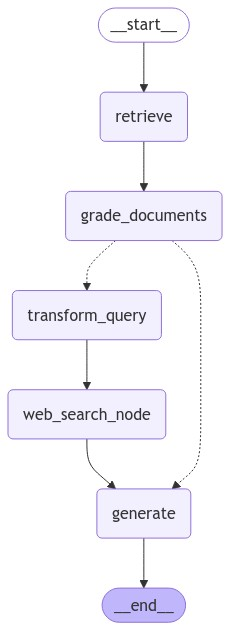

In [25]:
from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))

In [28]:
from pprint import pprint

inputs = {"question": "구글의 코드 작성 가이드"}
for output in app.stream(inputs):
    for key, value in output.items():
        pprint(f"Node '{key}':")
        # pprint(value, indent=2, width=80, depth=None)

pprint(value["generation"])

---검색---
"Node 'retrieve':"
---문서와 질문의 연관성 평가---
---평가: 연관 문서---
---평가: 연관 문서---
---평가: 연관 문서---
---평가: 연관 문서---
---문서 검토---
---연관 문서가 있음. 답변을 생성---
"Node 'grade_documents':"
---생성---
"Node 'generate':"
('구글의 코드 작성 가이드는 JavaScript와 Java 프로그래밍 언어에 대한 코딩 표준을 정의합니다. 이 가이드는 주로 강제 규칙에 '
 '중점을 두며, 미적 형식뿐만 아니라 다양한 코딩 관습을 다룹니다. 새로운 파일은 구글 스타일을 사용해야 하며, 기존 코드와의 일관성을 '
 '유지해야 합니다.')


In [29]:
from pprint import pprint

inputs = {"question": "C++ 깔끔하게 짜고싶다"}
for output in app.stream(inputs):
    for key, value in output.items():
        pprint(f"Node '{key}':")
        # pprint(value, indent=2, width=80, depth=None)

pprint(value["generation"])

---검색---
"Node 'retrieve':"
---문서와 질문의 연관성 평가---
---평가: 연관 없는 문서---
---평가: 연관 문서---
---평가: 연관 없는 문서---
---평가: 연관 없는 문서---
---문서 검토---
---연관 없는 문서가 있음. 질문을 변환---
"Node 'grade_documents':"
---질문 변환---
"Node 'transform_query':"
---웹 검색---
"Node 'web_search_node':"
---생성---
"Node 'generate':"
('C++ 코드를 깔끔하고 효율적으로 작성하려면, 적절한 알고리즘과 자료구조를 선택하고 불필요한 연산을 최소화해야 합니다. 또한, 코드의 '
 '가독성과 유지 보수성을 높이기 위해 문서화와 코드 리팩토링을 지속적으로 수행하는 것이 중요합니다. 마지막으로, 다양한 도구를 활용하여 '
 '코드 형식을 자동화하고, 여러 컴파일러에서 빌드하여 경고와 오류를 점검하는 것이 좋습니다.')
